<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Part 1. Vanilla Autoencoder

## 1.1. Preparing data


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os
import skimage.io
from skimage.transform import resize
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device} device')

Running on cuda device


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset

data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


Split the dataset into train and val; show some images to see what they look like, and cast the images to tensors so we can feed them to networks:

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.8)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=True)

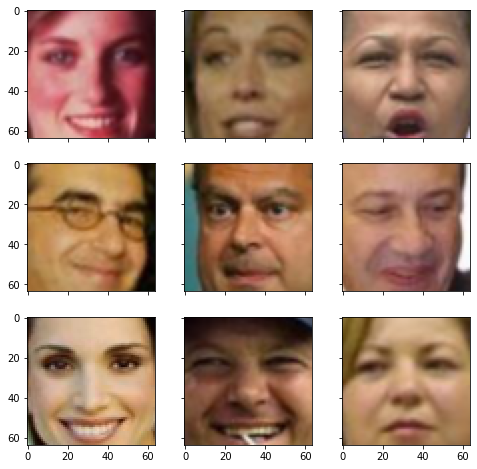

In [ ]:
sample_data = train_data[:9]
sample_attrs = train_attrs[:9]

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), \
                        sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
    fig_x.imshow(sample_data[i])
    fig_x.grid(False)

sample_data = torch.Tensor(sample_data)
sample_attrs = torch.Tensor(sample_attrs.astype(float).values)

## 1.2. Model architecture
In this section we will write and train a vanilla autoencoder.


<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


In [ ]:
latent_dim = 128

In [ ]:
from scipy.special.sf_error import SpecialFunctionError
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * 64 * 64, latent_dim)
        )
        self.fc = nn.Linear(latent_dim, 16 * 64 * 64)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, padding=1),
            torch.nn.Sigmoid()
        )

        self.double()
    def forward(self, x):
        
        latent_code = self.encoder(x)
        reconstruction = self.fc(latent_code).view(-1, 16, 64, 64)
        reconstruction = self.decoder(reconstruction)
        
        return reconstruction, latent_code

In [ ]:
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

## 1.3 Traing

Last part is to write the code for learning the autoencoder. In this case, it would be nice to sometimes see how the autoencoder produces images at this stage of training in the process. For example, after each epoch (running the train dataset through the autoeecoder), you can see what reconstructions have been obtained for some images val of the sample.

Oh, well, it would also be nice to show train and val loss plots during training =)

In [ ]:
import tqdm.notebook
from IPython.display import clear_output

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Epoch: 4


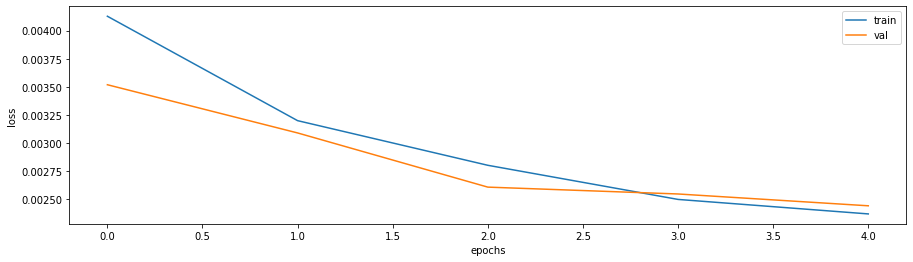

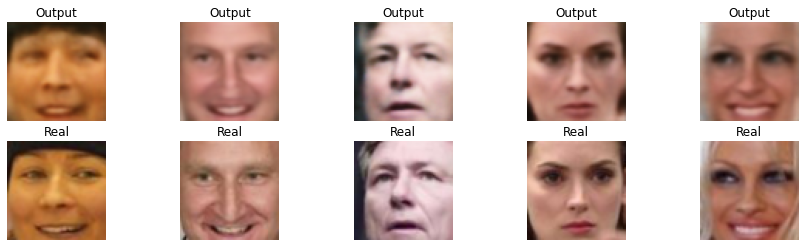

In [ ]:
epochs = 5
train_losses = []
val_losses = []

for epoch in range(epochs):
    autoencoder.train()
    epoch_losses = []
    for X_batch in tqdm.notebook.tqdm(train_loader):

        # [batch_size, height, width, channels] = [16, 64, 64, 3]
        X_batch = X_batch.transpose(2, 3).transpose(1, 2)
        
        # [batch_size, channels, height, width] = [16, 3, 64, 64]
        X_batch = X_batch.to(device)

        optimizer.zero_grad()
        reconstructed, latent = autoencoder(X_batch)
        loss = criterion(reconstructed, X_batch)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    
    train_losses.append(np.mean(epoch_losses))
    
    autoencoder.eval()
    with torch.no_grad():
        epoch_losses = []
        for X_batch in tqdm.notebook.tqdm(val_loader):
            X_batch = X_batch.transpose(2, 3).transpose(1, 2).to(device)
            reconstructed, latent = autoencoder(X_batch)
            loss = criterion(reconstructed, X_batch)
            epoch_losses.append(loss.item())
        val_losses.append(np.mean(epoch_losses))

    clear_output(wait=True)
    print(f'Epoch: {epoch}')
    
    # Drawing losses
    fig = plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='train')
    plt.plot(range(len(train_losses)), val_losses, label='val')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    # Drawing reconstructions
    Y_hat = reconstructed.detach().to('cpu')[:5]  # detach and put into cpu
    X = X_batch.detach().to('cpu')[:5]

    for k in range(5):
        plt.subplot(2, 5, k+1)
        plt.imshow(np.rollaxis(Y_hat[k].numpy(), 0, 3))
        plt.title('Output')
        plt.axis('off')

        plt.subplot(2, 5, k+6)
        plt.imshow(X[k].transpose(0, 1).transpose(1, 2))
        plt.title('Real')
        plt.axis('off')
    plt.show()


Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

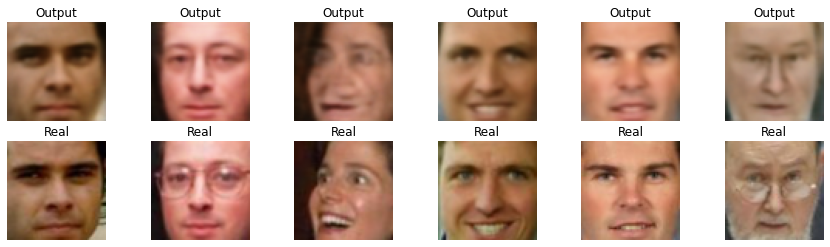

In [ ]:
imgs = torch.Tensor(val_data[:6]).transpose(2, 3).transpose(1, 2).double()
autoencoder.to('cpu')
representations, _ = autoencoder(imgs)

for k in range(6):
        plt.subplot(2, 6, k+1)
        plt.imshow(np.rollaxis(representations[k].detach().numpy(), 0, 3))
        plt.title('Output')
        plt.axis('off')

        plt.subplot(2, 6, k+7)
        plt.imshow(imgs[k].transpose(0, 1).transpose(1, 2))
        plt.title('Real')
        plt.axis('off')
plt.show()

Not bad, right? 

## 1.4. Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
imgs = torch.Tensor(val_data[:6]).transpose(2, 3).transpose(1, 2).double().to('cuda')
embeddings = autoencoder.encoder(imgs)


(tensor(0.9022, device='cuda:0', dtype=torch.float64,
        grad_fn=<StdMeanBackward0>),
 tensor(0.0447, device='cuda:0', dtype=torch.float64,
        grad_fn=<StdMeanBackward0>))

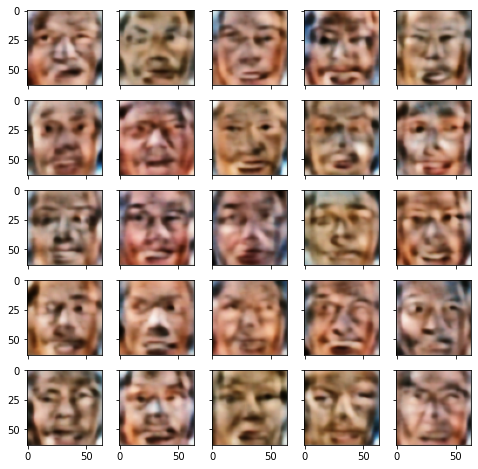

In [ ]:
autoencoder.to(device)

# Compute mean and standard deviation from latent representations
imgs = torch.Tensor(val_data[:6]).transpose(2, 3).transpose(1, 2).double().to('cuda')
embeddings = autoencoder.encoder(imgs)
mu, sigma = torch.mean(embeddings).item(), torch.std(embeddings).item()


# Let's generate 25 random vectors from latent_space
mu, sigma = 0.7, 1
s = np.random.normal(mu, sigma, (25, latent_dim))
z = torch.Tensor(s).to(device).double()
with torch.no_grad():
    tmp = autoencoder.fc(z).view(-1, 16, 64, 64)
    output = autoencoder.decoder(tmp)

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(8, 8), \
                        sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
    fig_x.imshow(output[i].transpose(0, 1).transpose(1, 2).cpu())

## Time to make it fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
# Here we select smiley and sad images 
smiley_imgs = train_data[[6, 7, 9, 21, 23, 49, 51, 55, 58, 64, 67, 76, 96, 97, 100]]
sad_imgs = train_data[[8, 13, 14, 15, 27, 40, 42, 46, 52, 53, 59, 65, 69, 71, 74]]

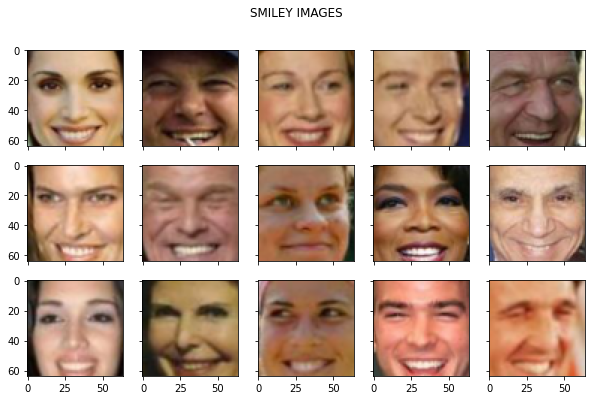

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10, 6), \
                        sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
    fig_x.imshow(smiley_imgs[i])
    fig_x.grid(False)
fig.suptitle('SMILEY IMAGES');

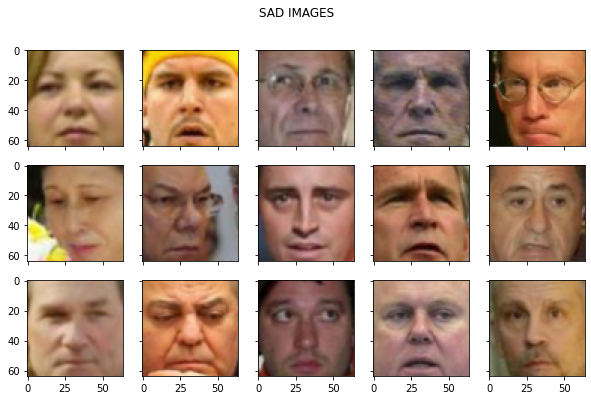

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10, 6), \
                        sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
    fig_x.imshow(sad_imgs[i])
    fig_x.grid(False)
fig.suptitle('SAD IMAGES');

In [ ]:
smiley_tens = torch.Tensor(smiley_imgs).transpose(2, 3).transpose(1, 2).double().to('cuda')
_, smiley_latent = autoencoder(smiley_tens)

sad_tens = torch.Tensor(sad_imgs).transpose(2, 3).transpose(1, 2).double().to('cuda')
_, sad_latent = autoencoder(sad_tens)

In [ ]:
torch.mean(smiley_latent, axis=0).shape

torch.Size([])

In [ ]:
mean_smiley_person = torch.mean(smiley_latent, axis=0)
mean_sad_person = torch.mean(sad_latent, axis=0)

smile_vector = mean_smiley_person - mean_sad_person

In [ ]:
# Making a sad person happier!

sad_person = sad_imgs[0]
_, sad_latent = autoencoder(sad_tens[0].unsqueeze(0))
happy_person = sad_latent + smile_vector.unsqueeze(0)
happy_person = autoencoder.fc(happy_person).view(-1, 16, 64, 64)
happy_person = autoencoder.decoder(happy_person).squeeze(0)

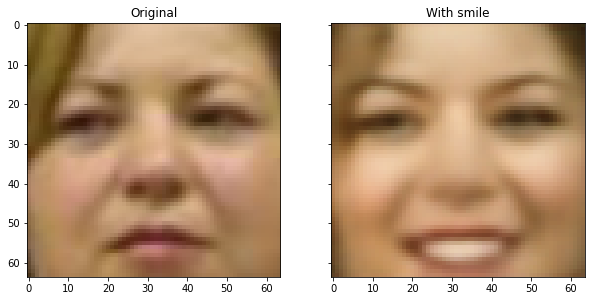

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), \
                        sharey=True)

ax[0].imshow(sad_person)
ax[0].set_title('Original')

ax[1].imshow(happy_person.cpu().detach().transpose(0, 1).transpose(1, 2))
ax[1].set_title('With smile');

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Part 2: Variational Autoencoder

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [3]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Model architecture and training

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [4]:
features = 16

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 28 * 28, 2 * features)
            )

        # To transform back to image
        self.fc_decoder = nn.Linear(features, 64 * 28 * 28)


        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, padding=1),
            torch.nn.Sigmoid()
        )

    def encode(self, x):
        res = self.encoder(x).view(-1, 2, features)
        # get 'mu' and 'log_sigma'
        mu = res[:, 0, :] # the first feature values as mean
        log_sigma = res[:, 1, :] # the other feature values as variance

        return mu, log_sigma
    
    def gaussian_sampler(self, mu, log_sigma):
        if self.training:
            std = torch.exp(log_sigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        
        res = self.fc_decoder(z).view(-1, 64, 28, 28)
        res = self.decoder(res)
        return res

    def sample(self, z):
        generated = self.fc_decoder(z).view(-1, 64, 28, 28)
        generated = self.decoder(generated)
        return generated

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, log_sigma и reconstruction>
        mu, log_sigma = self.encode(x)

        samples = self.gaussian_sampler(mu, log_sigma)

        reconstruction = self.decode(samples)
        return reconstruction, mu, log_sigma

    def get_latent_vector(self, x):
        mu, log_sigma = self.encode(x)
        samples = self.gaussian_sampler(mu, log_sigma)
        return samples

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [5]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [6]:
criterion = loss_vae
autoencoder = VAE().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

In [7]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

from matplotlib import rcParams

n_epochs = 5
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []

    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch[0].to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
          reconstruction, mu, logsigma = autoencoder(batch[0].to(device))
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/5 [00:00<?, ?it/s]

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [8]:
autoencoder.eval()
with torch.no_grad():
    for batch in test_loader:
        reconstruction, mu, logsigma = autoencoder(batch[0].to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch[0].numpy()
        break

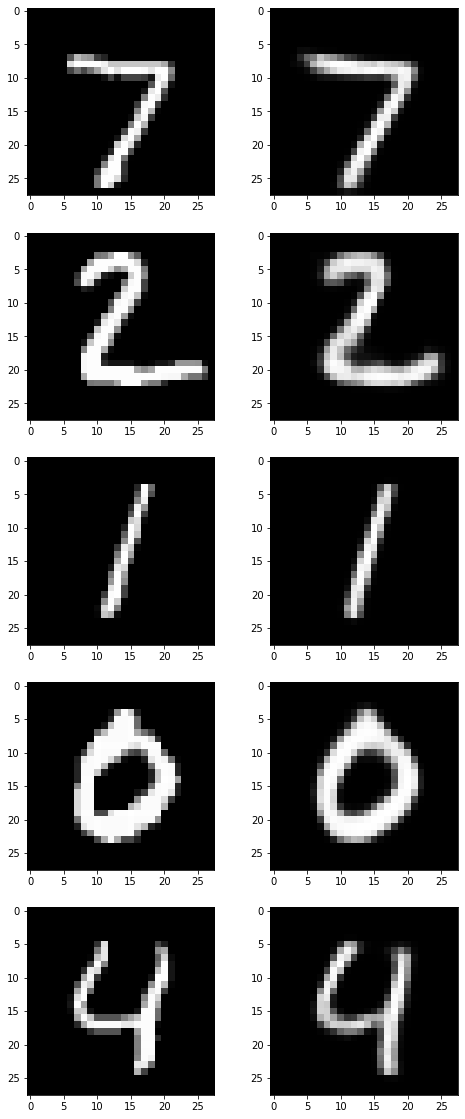

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(gt[0], cmap='gray')
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(res[0], cmap='gray')

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

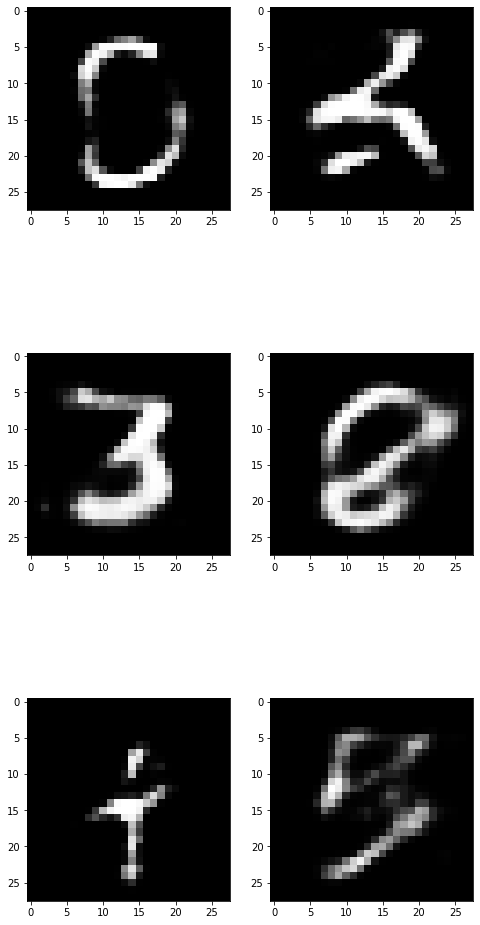

In [10]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 16) for i in range(6)])
output = autoencoder.sample(torch.FloatTensor(z).to(device))

plt.figure(figsize=(8, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(generated[0], cmap='gray')

plt.show()

## 2.2. Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [26]:
from sklearn.manifold import TSNE

# Test latent representaitons
test_latent = [autoencoder.get_latent_vector(batch[0].to(device)).cpu().detach().numpy() for batch in test_loader]
test_latent = test_latent[:-1]  # last batch is shortened
test_latent = np.stack(test_latent).reshape((-1, 16))

# Digits will be used for coloring
test_digits = [batch[1] for batch in test_loader]
test_digits = test_digits[:-1]
test_digits = torch.stack(test_digits)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


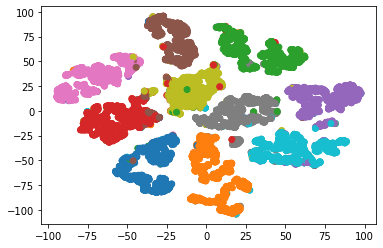

In [28]:
test_latent = TSNE(n_components=2).fit_transform(test_latent)
plt.scatter(test_latent[:, 0], test_latent[:, 12], c=test_digits, cmap='tab10')

Что вы думаете о виде латентного представления?

__Congrats v2.0!__